In [1]:
from __future__ import division
from __future__ import print_function
import yaml
import cantera as ct
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from textwrap import wrap
import scipy.optimize

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.6.0a2


In [2]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

In [2]:
# These are the sensitive reactions that we will tweak
sensitive_rxns = ["H2O2(18) (+M) <=> 2 OH(15) (+M)", "CH4(10) + O2(2) <=> CH3(19) + HO2(17)",
                 "C7H15(686) + H2O2(18) <=> C7H16(1) + HO2(17)", "C2H4(11) + OH(15) <=> C2H3(23) + H2O(8)",
                 "C2H4(11) + HO2(17) <=> C2H5(34) + O2(2)", "C7H15(683) + H2O2(18) <=> C7H16(1) + HO2(17)",
                 "2 HO2(17) <=> H2O2(18) + O2(2)", "HO2(17) + OH(15) <=> H2O(8) + O2(2)",
                 "CH3(19) + HO2(17) <=> CH3O(31) + OH(15)"
                ]
      
gas = ct.Solution("/home/chao/bm_test/n_heptane/n_heptane_annotated.yaml")

# extract the reaction indices
sens_indices = []
for r in sensitive_rxns:
    duplicate_rxns = []
    for i, rxn in enumerate(gas.reactions()):
        if rxn.equation == r:
            duplicate_rxns.append(i)
    sens_indices.append(duplicate_rxns)
print(sens_indices)

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474

[[21], [80], [871], [243], [249], [917], [19, 20], [18], [96]]


In [ ]:
# tweak the kinetics parameter
for rxn_idx in sens_indices:
    reactorTemperature = 1000 #Kelvin
    reactorPressure = 8*101325.0 #Pascals

    gas.TP = reactorTemperature, reactorPressure

    # Define the fuel, oxidizer and set the stoichiometry
    gas.set_equivalence_ratio(phi=1.0, fuel='C7H16(1)', oxidizer={'O2(2)':1.0, 'N2':3.76})
    for i in rxn_idx:
        if gas.reaction(i).reaction_type == 'elementary':
            R = gas.reaction(i)
            new_A = R.rate.pre_exponential_factor * 1.01
            b = R.rate.temperature_exponent
            E = R.rate.activation_energy
            rate = ct.Arrhenius(new_A, b, E)
            R.rate = rate
            gas.modify_reaction(i, R)
        elif gas.reaction(i).reaction_type == 'falloff':
            R = gas.reaction(i)
            new_high_A = R.high_rate.pre_exponential_factor * 1.01
            high_b = R.high_rate.temperature_exponent
            high_E = R.high_rate.activation_energy
            new_high_rate = ct.Arrhenius(new_high_A, high_b, high_E)
            new_low_A = R.low_rate.pre_exponential_factor * 1.01
            low_b = R.low_rate.temperature_exponent
            low_E = R.low_rate.activation_energy
            new_low_rate = ct.Arrhenius(new_low_A, low_b, low_E)
            R.high_rate = new_high_rate
            R.low_rate = new_low_rate
            gas.modify_reaction(i, R)
        elif gas.reaction(i).reaction_type == 'pressure-dependent-Arrhenius':
            R = gas.reaction(i)
            new_rates = []
            for rate in R.rates:
                new_A = rate[1].pre_exponential_factor * 1.01
                b = rate[1].temperature_exponent
                E = rate[1].activation_energy
                new_rate = ct.Arrhenius(new_A, b, E)
                new_rates.append((rate[0], new_rate))
            R.rates = new_rates
            gas.modify_reaction(i, R)
        elif gas.reaction(i).reaction_type == 'Blowers-Masel':
            R = gas.reaction(i)
            new_A = R.rate.pre_exponential_factor * 1.01
            n = R.rate.temperature_exponent
            E0 = R.rate.intrinsic_activation_energy
            b = R.rate.bond_energy
            new_rate = ct.BlowersMasel(new_A, n, E0,b)
            R.rate = new_rate
            gas.modify_reaction(i, R)


    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    stateVariableNames = []
    # now compile a list of all variables for which we will store data
    stateVariableNames += [r.component_name(item) for item in range(r.n_vars)]

    # use the above list to create a DataFrame
    timeHistory = pd.DataFrame(columns=stateVariableNames)

    #Tic
    t0 = time.time()

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimatedIgnitionDelayTime = 1
    t = 0

    counter = 1;
    while(t < estimatedIgnitionDelayTime):
        t = reactorNetwork.step()
        if (counter%10 == 0):
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            timeHistory.loc[t] = reactorNetwork.get_state()
        counter+=1

    # We will use the 'oh' species to compute the ignition delay
    tau = ignitionDelay(timeHistory, 'OH(15)')

    #Toc
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

    # If you want to save all the data - molefractions, temperature, pressure, etc
    # uncomment the next line
    timeHistory.to_csv(f"time_history_normal_kinetics_bf{rxn_idx}.csv")

In [3]:
df_normal = pd.read_csv('/home/chao/bm_test/time_history_normal_nh.csv')
original_oh = df_normal.loc[:,'OH(15)'][df_normal.loc[:,'OH(15)'].idxmax()]
sens_value_normal = []
for rxn_list in sens_indices:
    df = pd.read_csv(f'time_history_normal_kinetics_bf{rxn_list}.csv')
    perturbed_oh = df.loc[:,'OH(15)'][df['OH(15)'].idxmax()]
    sens_value_normal.append((original_oh - perturbed_oh) / original_oh / 0.01)
print(sens_value_normal)

[-0.009698854807668978, 0.0003404029765221229, -0.009660584455089632, -0.0069612607341389115, -0.006400857694411427, -0.005618765877901661, -0.009627257933143963, -0.004980744916442377, -0.005728934753516041]


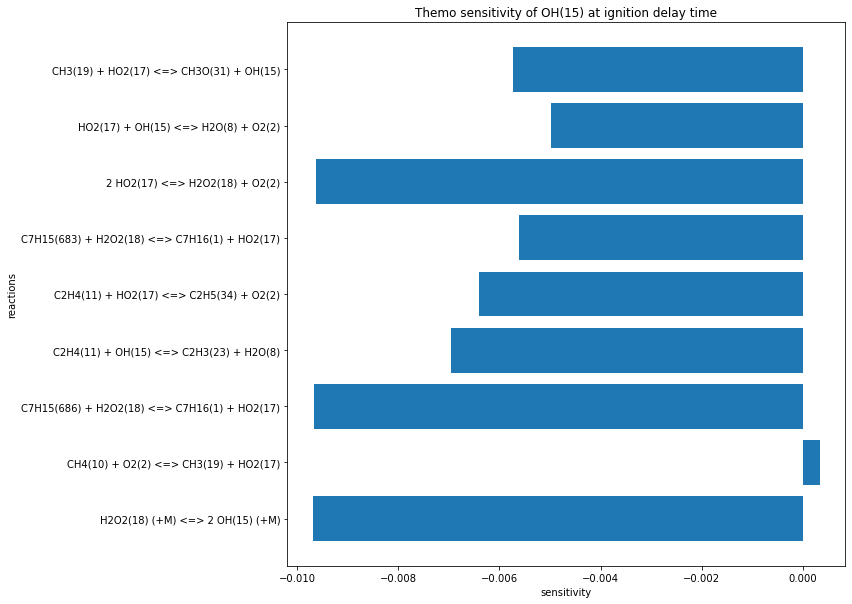

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.barh(sensitive_rxns,sens_value_normal)
plt.title('Themo sensitivity of OH(15) at ignition delay time')
plt.ylabel('reactions')
plt.xlabel('sensitivity')
plt.show()

## run the same simulation for the model with B-M reactions

In [3]:
# These are the sensitive reactions that we will tweak
sensitive_rxns = ["H2O2(18) (+M) <=> 2 OH(15) (+M)", "CH4(10) + O2(2) <=> CH3(19) + HO2(17)",
                 "C7H15(686) + H2O2(18) <=> C7H16(1) + HO2(17)", "C2H4(11) + OH(15) <=> C2H3(23) + H2O(8)",
                 "C2H4(11) + HO2(17) <=> C2H5(34) + O2(2)", "C7H15(683) + H2O2(18) <=> C7H16(1) + HO2(17)",
                 "2 HO2(17) <=> H2O2(18) + O2(2)", "HO2(17) + OH(15) <=> H2O(8) + O2(2)",
                 "CH3(19) + HO2(17) <=> CH3O(31) + OH(15)"
                ]
      
gas = ct.Solution("/home/chao/bm_test/n_heptane/n_heptane_bm_new.yaml")

# extract the reaction indices
sens_indices = []
for r in sensitive_rxns:
    duplicate_rxns = []
    for i, rxn in enumerate(gas.reactions()):
        if rxn.equation == r:
            duplicate_rxns.append(i)
    sens_indices.append(duplicate_rxns)
print(sens_indices)

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474

[[21], [80], [871], [243], [249], [917], [19, 20], [18], [96]]


In [4]:
# tweak the kinetics parameter
for rxn_idx in sens_indices:
    reactorTemperature = 1000 #Kelvin
    reactorPressure = 8*101325.0 #Pascals

    gas.TP = reactorTemperature, reactorPressure

    # Define the fuel, oxidizer and set the stoichiometry
    gas.set_equivalence_ratio(phi=1.0, fuel='C7H16(1)', oxidizer={'O2(2)':1.0, 'N2':3.76})
    for i in rxn_idx:
        if gas.reaction(i).reaction_type == 'elementary':
            R = gas.reaction(i)
            new_A = R.rate.pre_exponential_factor * 1.01
            b = R.rate.temperature_exponent
            E = R.rate.activation_energy
            rate = ct.Arrhenius(new_A, b, E)
            R.rate = rate
            gas.modify_reaction(i, R)
        elif gas.reaction(i).reaction_type == 'falloff':
            R = gas.reaction(i)
            new_high_A = R.high_rate.pre_exponential_factor * 1.01
            high_b = R.high_rate.temperature_exponent
            high_E = R.high_rate.activation_energy
            new_high_rate = ct.Arrhenius(new_high_A, high_b, high_E)
            new_low_A = R.low_rate.pre_exponential_factor * 1.01
            low_b = R.low_rate.temperature_exponent
            low_E = R.low_rate.activation_energy
            new_low_rate = ct.Arrhenius(new_low_A, low_b, low_E)
            R.high_rate = new_high_rate
            R.low_rate = new_low_rate
            gas.modify_reaction(i, R)
        elif gas.reaction(i).reaction_type == 'pressure-dependent-Arrhenius':
            R = gas.reaction(i)
            new_rates = []
            for rate in R.rates:
                new_A = rate[1].pre_exponential_factor * 1.01
                b = rate[1].temperature_exponent
                E = rate[1].activation_energy
                new_rate = ct.Arrhenius(new_A, b, E)
                new_rates.append((rate[0], new_rate))
            R.rates = new_rates
            gas.modify_reaction(i, R)
        elif gas.reaction(i).reaction_type == 'Blowers-Masel':
            R = gas.reaction(i)
            new_A = R.rate.pre_exponential_factor * 1.01
            n = R.rate.temperature_exponent
            E0 = R.rate.intrinsic_activation_energy
            b = R.rate.bond_energy
            new_rate = ct.BlowersMasel(new_A, n, E0,b)
            R.rate = new_rate
            gas.modify_reaction(i, R)


    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    stateVariableNames = []
    # now compile a list of all variables for which we will store data
    stateVariableNames += [r.component_name(item) for item in range(r.n_vars)]

    # use the above list to create a DataFrame
    timeHistory = pd.DataFrame(columns=stateVariableNames)

    #Tic
    t0 = time.time()

    # This is a starting estimate. If you do not get an ignition within this time, increase it
    estimatedIgnitionDelayTime = 1
    t = 0

    counter = 1;
    while(t < estimatedIgnitionDelayTime):
        t = reactorNetwork.step()
        if (counter%10 == 0):
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            timeHistory.loc[t] = reactorNetwork.get_state()
        counter+=1

    # We will use the 'oh' species to compute the ignition delay
    tau = ignitionDelay(timeHistory, 'OH(15)')

    #Toc
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

    # If you want to save all the data - molefractions, temperature, pressure, etc
    # uncomment the next line
    timeHistory.to_csv(f"time_history_bm_new_kinetics_bf{rxn_idx}.csv")

Computed Ignition Delay: 1.117e-02 seconds. Took 2.37s to compute
Computed Ignition Delay: 1.119e-02 seconds. Took 2.30s to compute
Computed Ignition Delay: 1.117e-02 seconds. Took 2.15s to compute
Computed Ignition Delay: 1.115e-02 seconds. Took 2.31s to compute
Computed Ignition Delay: 1.117e-02 seconds. Took 2.38s to compute
Computed Ignition Delay: 1.116e-02 seconds. Took 2.35s to compute
Computed Ignition Delay: 1.117e-02 seconds. Took 2.28s to compute
Computed Ignition Delay: 1.118e-02 seconds. Took 2.25s to compute
Computed Ignition Delay: 1.117e-02 seconds. Took 2.45s to compute


In [3]:
rxns_bm = []
df_bm = pd.read_csv('/home/chao/bm_test/time_history.csv')
original_oh = df_bm.loc[:,'OH(15)'][df_bm.loc[:,'OH(15)'].idxmax()]
sens_value_bm = []
for rxn_list in sens_indices:
    df = pd.read_csv(f'time_history_bm_kinetics_bf{rxn_list}.csv')
    perturbed_oh = df.loc[:,'OH(15)'][df['OH(15)'].idxmax()]
    sens_value_bm.append((original_oh - perturbed_oh) / original_oh / 0.01)
    rxns_bm.append(gas.reaction(rxn_list[0]).equation)
print(sens_value_bm, rxns_bm)

[-0.007327905547332901, -0.009592075097729663, -0.0031989631626694144, -0.009086532522764671, -0.009759217527958917, -0.008289337401075205, -0.008880666072603691, -0.007818727290118484, -0.008772406708812457] ['H2O2(18) (+M) <=> 2 OH(15) (+M)', 'CH4(10) + O2(2) <=> CH3(19) + HO2(17)', 'C7H15(686) + H2O2(18) <=> C7H16(1) + HO2(17)', 'C2H4(11) + OH(15) <=> C2H3(23) + H2O(8)', 'C2H4(11) + HO2(17) <=> C2H5(34) + O2(2)', 'C7H15(683) + H2O2(18) <=> C7H16(1) + HO2(17)', '2 HO2(17) <=> H2O2(18) + O2(2)', 'HO2(17) + OH(15) <=> H2O(8) + O2(2)', 'CH3(19) + HO2(17) <=> CH3O(31) + OH(15)']


In [4]:
rxns_normal = []
df_normal = pd.read_csv('/home/chao/bm_test/time_history_normal_nh.csv')
original_oh = df_normal.loc[:,'OH(15)'][df_normal.loc[:,'OH(15)'].idxmax()]
sens_value_normal = []
for rxn_list in sens_indices:
    df = pd.read_csv(f'time_history_normal_kinetics_bf{rxn_list}.csv')
    perturbed_oh = df.loc[:,'OH(15)'][df['OH(15)'].idxmax()]
    sens_value_normal.append((original_oh - perturbed_oh) / original_oh / 0.01)
    rxns_normal.append(gas.reaction(rxn_list[0]).equation)
print(sens_value_normal, rxns_normal)

[-0.009698854807668978, 0.0003404029765221229, -0.009660584455089632, -0.0069612607341389115, -0.006400857694411427, -0.005618765877901661, -0.009627257933143963, -0.004980744916442377, -0.005728934753516041] ['H2O2(18) (+M) <=> 2 OH(15) (+M)', 'CH4(10) + O2(2) <=> CH3(19) + HO2(17)', 'C7H15(686) + H2O2(18) <=> C7H16(1) + HO2(17)', 'C2H4(11) + OH(15) <=> C2H3(23) + H2O(8)', 'C2H4(11) + HO2(17) <=> C2H5(34) + O2(2)', 'C7H15(683) + H2O2(18) <=> C7H16(1) + HO2(17)', '2 HO2(17) <=> H2O2(18) + O2(2)', 'HO2(17) + OH(15) <=> H2O(8) + O2(2)', 'CH3(19) + HO2(17) <=> CH3O(31) + OH(15)']


In [5]:
rxns_bm_new = []
df_bm_new = pd.read_csv('/home/chao/bm_test/bf_kinetics_sens/time_history_bm_new_kinetics_bf.csv')
original_oh = df_bm_new.loc[:,'OH(15)'][df_bm_new.loc[:,'OH(15)'].idxmax()]
sens_value_bm_new = []
for rxn_list in sens_indices:
    df = pd.read_csv(f'time_history_bm_new_kinetics_bf{rxn_list}.csv')
    perturbed_oh = df.loc[:,'OH(15)'][df['OH(15)'].idxmax()]
    sens_value_bm_new.append((original_oh - perturbed_oh) / original_oh / 0.01)
    rxns_bm_new.append(gas.reaction(rxn_list[0]).equation)
print(sens_value_bm_new, rxns_bm_new)

[-0.008963909087021183, -0.00032013433919864044, -0.006349245336912349, -0.009043923936700338, -0.0055171779938916745, -0.0005411995803259103, -0.0038261725036725053, -0.0072596911096190105, -0.0019797966000373994] ['H2O2(18) (+M) <=> 2 OH(15) (+M)', 'CH4(10) + O2(2) <=> CH3(19) + HO2(17)', 'C7H15(686) + H2O2(18) <=> C7H16(1) + HO2(17)', 'C2H4(11) + OH(15) <=> C2H3(23) + H2O(8)', 'C2H4(11) + HO2(17) <=> C2H5(34) + O2(2)', 'C7H15(683) + H2O2(18) <=> C7H16(1) + HO2(17)', '2 HO2(17) <=> H2O2(18) + O2(2)', 'HO2(17) + OH(15) <=> H2O(8) + O2(2)', 'CH3(19) + HO2(17) <=> CH3O(31) + OH(15)']


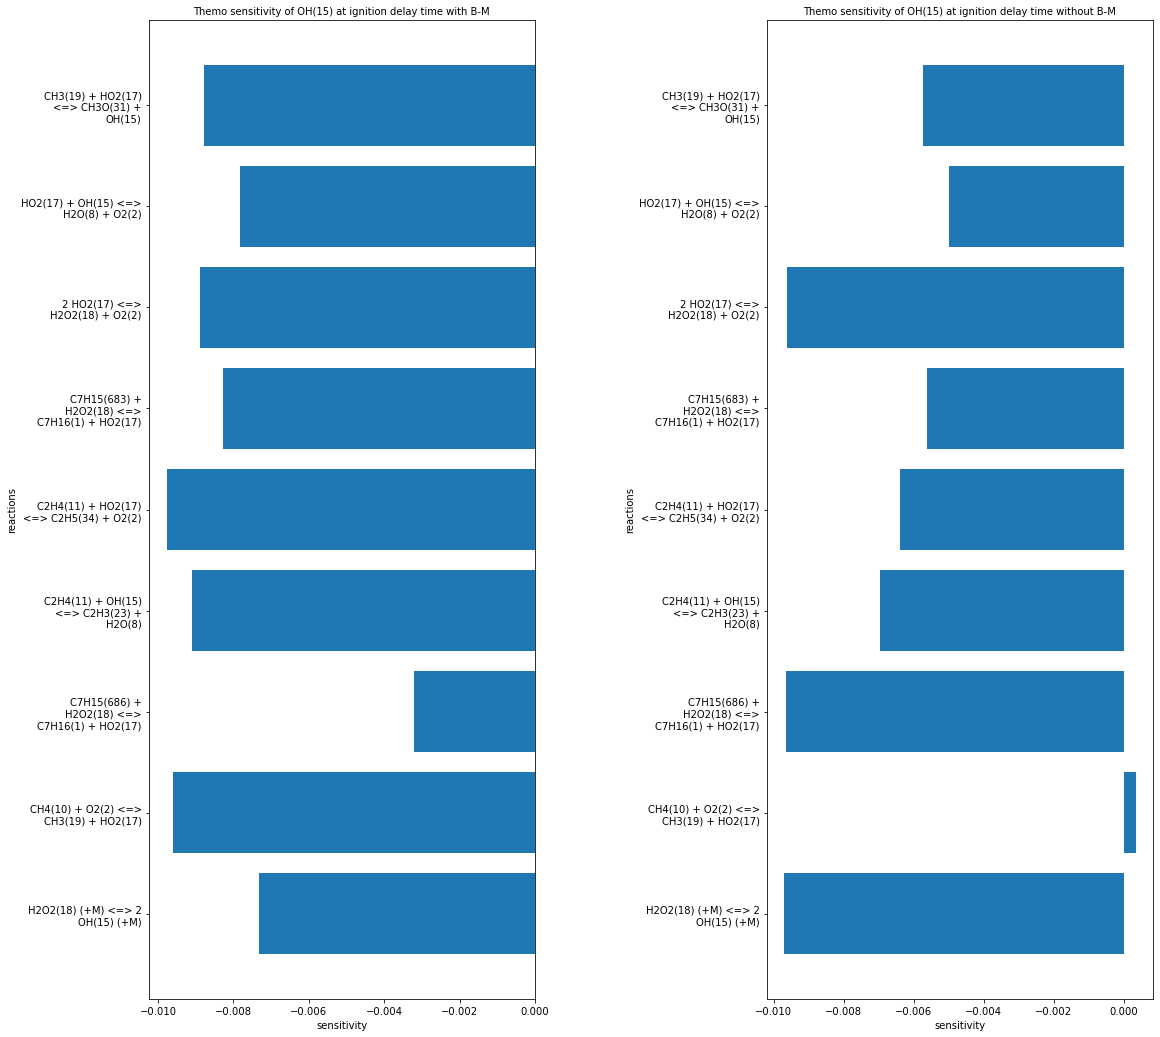

In [7]:
figure, axes = plt.subplots(ncols=2, figsize=(18,18))

rxns_bm = [ '\n'.join(wrap(s, 20)) for s in rxns_bm ]
rxns_normal = [ '\n'.join(wrap(s, 20)) for s in rxns_normal ]
axes[0].barh(rxns_bm,sens_value_bm)
axes[1].barh(rxns_normal, sens_value_normal)
# axes[0,0].title('Themo sensitivity of OH(15) at ignition delay time for n_heptane without B-M')
axes[0].set_title('Themo sensitivity of OH(15) at ignition delay time with B-M', fontsize=10)
axes[1].set_title('Themo sensitivity of OH(15) at ignition delay time without B-M', fontsize=10)

axes[0].set(ylabel='reactions', xlabel='sensitivity')
axes[1].set(ylabel='reactions', xlabel='sensitivity')
plt.subplots_adjust(wspace=0.6)

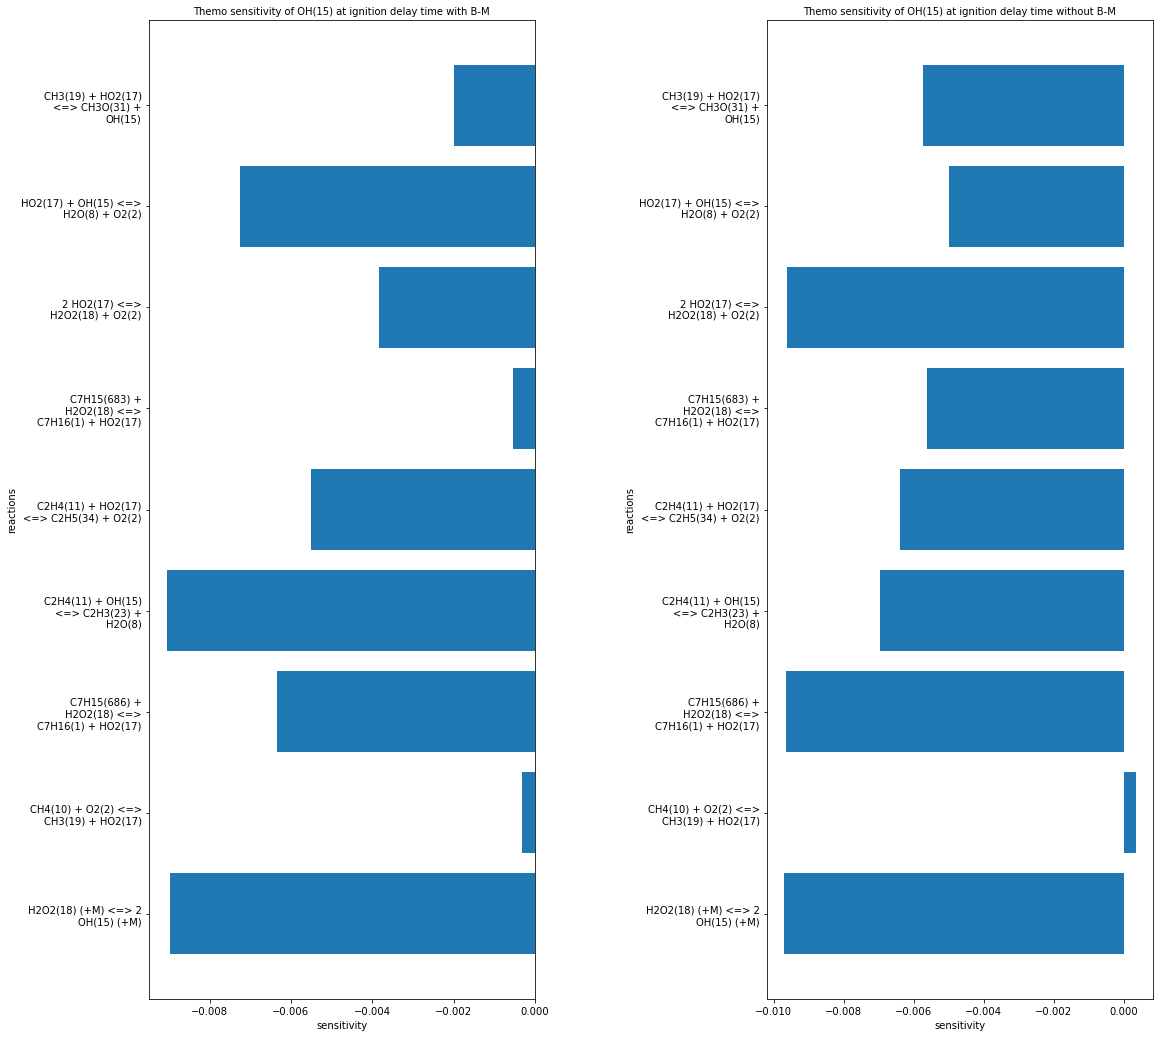

In [6]:
figure, axes = plt.subplots(ncols=2, figsize=(18,18))

rxns_bm_new = [ '\n'.join(wrap(s, 20)) for s in rxns_bm_new ]
rxns_normal = [ '\n'.join(wrap(s, 20)) for s in rxns_normal ]
axes[0].barh(rxns_bm_new,sens_value_bm_new)
axes[1].barh(rxns_normal, sens_value_normal)
# axes[0,0].title('Themo sensitivity of OH(15) at ignition delay time for n_heptane without B-M')
axes[0].set_title('Themo sensitivity of OH(15) at ignition delay time with B-M', fontsize=10)
axes[1].set_title('Themo sensitivity of OH(15) at ignition delay time without B-M', fontsize=10)

axes[0].set(ylabel='reactions', xlabel='sensitivity')
axes[1].set(ylabel='reactions', xlabel='sensitivity')
plt.subplots_adjust(wspace=0.6)

In [7]:
gas = ct.Solution("/home/chao/bm_test/n_heptane/n_heptane_bm.yaml")
for r in sens_indices:
    print(r[0], gas.reaction(r[0]).equation, gas.reaction(r[0]).reaction_type)

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474

21 H2O2(18) (+M) <=> 2 OH(15) (+M) falloff
80 CH4(10) + O2(2) <=> CH3(19) + HO2(17) elementary
871 C7H15(686) + H2O2(18) <=> C7H16(1) + HO2(17) Blowers-Masel
243 C2H4(11) + OH(15) <=> C2H3(23) + H2O(8) elementary
249 C2H4(11) + HO2(17) <=> C2H5(34) + O2(2) pressure-dependent-Arrhenius
917 C7H15(683) + H2O2(18) <=> C7H16(1) + HO2(17) Blowers-Masel
19 2 HO2(17) <=> H2O2(18) + O2(2) elementary
18 HO2(17) + OH(15) <=> H2O(8) + O2(2) elementary
96 CH3(19) + HO2(17) <=> CH3O(31) + OH(15) elementary


In [8]:
gas = ct.Solution("/home/chao/bm_test/n_heptane/n_heptane_bm_new.yaml")
for r in sens_indices:
    print(r[0], gas.reaction(r[0]).equation, gas.reaction(r[0]).reaction_type)

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474

21 H2O2(18) (+M) <=> 2 OH(15) (+M) falloff
80 CH4(10) + O2(2) <=> CH3(19) + HO2(17) elementary
871 C7H15(686) + H2O2(18) <=> C7H16(1) + HO2(17) Blowers-Masel
243 C2H4(11) + OH(15) <=> C2H3(23) + H2O(8) elementary
249 C2H4(11) + HO2(17) <=> C2H5(34) + O2(2) pressure-dependent-Arrhenius
917 C7H15(683) + H2O2(18) <=> C7H16(1) + HO2(17) Blowers-Masel
19 2 HO2(17) <=> H2O2(18) + O2(2) Blowers-Masel
18 HO2(17) + OH(15) <=> H2O(8) + O2(2) Blowers-Masel
96 CH3(19) + HO2(17) <=> CH3O(31) + OH(15) Blowers-Masel


## change 3 sensitive rxns to B-M type

In [3]:
gas = ct.Solution("/home/chao/bm_test/n_heptane/n_heptane_bm.yaml")

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474



In [4]:
import yaml
with open("/home/chao/bm_test/n_heptane/n_heptane_bm.yaml", 'r') as f:
    model = yaml.load(f, Loader=yaml.FullLoader)

In [22]:
model['reactions'][96]

{'equation': 'HO2(17) + CH3(19) <=> OH(15) + CH3O(31)',
 'note': 'Reaction index: Chemkin #97; RMG #94\nLibrary reaction: Klippenstein_Glarborg2016\nFlux pairs: CH3(19), CH3O(31); HO2(17), OH(15);',
 'rate-constant': {'A': 1000000000000.0, 'Ea': 0.688, 'b': 0.269}}

In [5]:
def get_Ea_from_E0_dH(E0, dHrxn, w0=1e9):
        """
        Return the activation energy in J/kmol corresponding to the given
        E0, enthalpy of reaction `dHrxn`, and w0, all in J/kmol.
        """
        E0 = float(E0)
        w0 = max(w0, 2*E0)
        assert w0 >= 2*E0, f"seems to work best when w0 > 2*Eo = {2*E0/1e3:.1f} kJ/mol, but w0={w0/1e3:.1f} kJ/mol"
        
        if E0 == dHrxn == 0:
            return 0
        if dHrxn < -4 * E0:
            return 0.0
        elif dHrxn > 4 * E0:
            return dHrxn
        else:
            Vp = 2 * w0 * (2 * w0 + 2 * E0) / (2 * w0 - 2 * E0)
            return (w0 + dHrxn / 2.0) * (Vp - 2 * w0 + dHrxn) ** 2 / (Vp ** 2 - (2 * w0) ** 2 + dHrxn ** 2)

def get_E0_from_Ea_dH(i, Ea, dHrxn, w0=1e9, plot=False):
    """
    Return the E0 in J/mol corresponding to the given Ea and dHrxn and w0 in J/mol.
    """
    def f(E0):
        return Ea - get_Ea_from_E0_dH(E0, dHrxn, w0=w0)
    E0_guess = Ea*.5 if dHrxn>0 else max(Ea*8,30e6)
    E0 = scipy.optimize.fsolve(f, E0_guess)[0]
    #print(f"E0 = {E0}")
        
    if plot:
        plt.ioff()
        plt.clf()
        dHs = np.linspace(min(-5*E0,dHrxn),max(5*E0,dHrxn))
        Eas = np.vectorize(lambda dH: get_Ea_from_E0_dH(E0, dH, w0=w0))(dHs)
        plt.plot(dHs/1e6, Eas/1e6)
        plt.plot(dHrxn/1e6, Ea/1e6, 'ro')
        plt.plot(0,E0/1e6,'bx')
        plt.text(0,E0/1e6,f'$E_0={E0/1e6:.1f}$ kJ/mol')
        plt.title('reaction {}'.format(i))
        plt.show()
    
    if not np.isclose(Ea, get_Ea_from_E0_dH(E0, dHrxn), rtol=0.002):
        print(f"Warning: {Ea} not close to {get_Ea_from_E0_dH(E0, dHrxn)}")
        
    return E0

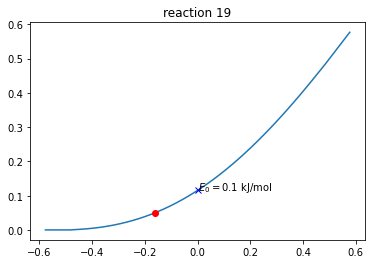

/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


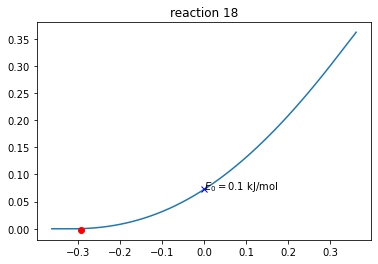

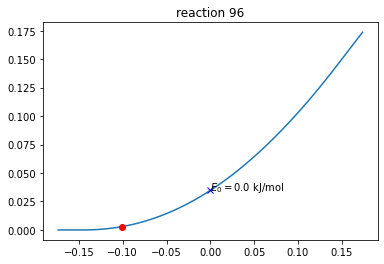

In [6]:
bm_rxns = []
for i in [19,18,96]:
    model['reactions'][i]['type'] = 'Blowers-Masel'
    rc = model['reactions'][i]['rate-constant']
    Ea0 = get_E0_from_Ea_dH(i, rc['Ea'] * 4184, gas.delta_enthalpy[i] / 1000, w0=1e6, plot=True)
    rc['Ea0'] = float(Ea0) *  0.2390 / 1000
    rc['w'] = 239.0
    del rc['Ea']
    bm_rxns.append(model['reactions'][i])

In [7]:
for i in range(len(bm_rxns)):
    for j in range(len(model['reactions'])):
        if bm_rxns[i]['equation'] == model['reactions'][j]['equation']:
            model['reactions'][j] = bm_rxns[i]
with open('/home/chao/bm_test/n_heptane/n_heptane_bm_new.yaml', 'w') as f:
    yaml.dump(model, f, default_flow_style=False)

## run IDT simulation with new model

In [4]:
gas = ct.Solution("/home/chao/bm_test/n_heptane/n_heptane_bm_new.yaml")
reactorTemperature = 1000 #Kelvin
reactorPressure = 8*101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel='C7H16(1)', oxidizer={'O2(2)':1.0, 'N2':3.76})

r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

stateVariableNames = []
# now compile a list of all variables for which we will store data
stateVariableNames += [r.component_name(item) for item in range(r.n_vars)]

# use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=stateVariableNames)

#Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimatedIgnitionDelayTime = 1
t = 0

counter = 1;
while(t < estimatedIgnitionDelayTime):
    t = reactorNetwork.step()
    if (counter%10 == 0):
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        timeHistory.loc[t] = reactorNetwork.get_state()
    counter+=1

# We will use the 'oh' species to compute the ignition delay
tau = ignitionDelay(timeHistory, 'OH(15)')

#Toc
t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
timeHistory.to_csv(f"time_history_bm_new_kinetics_bf.csv")

For species HOCHO(59), discontinuity in h/RT detected at Tmid = 1000.0
	Value computed using low-temperature polynomial:  -40.36040333333333
	Value computed using high-temperature polynomial: -38.16784474

Computed Ignition Delay: 1.122e-02 seconds. Took 2.37s to compute


## sensitivity before the IDT